# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4333568/11490434 [==========>...................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 13:13 - loss: 0.6935

  27/1875 [..............................] - ETA: 3s - loss: 0.5582   

  53/1875 [..............................] - ETA: 3s - loss: 0.4797

  79/1875 [>.............................] - ETA: 3s - loss: 0.4369

 104/1875 [>.............................] - ETA: 3s - loss: 0.4098

 130/1875 [=>............................] - ETA: 3s - loss: 0.3895

 157/1875 [=>............................] - ETA: 3s - loss: 0.3732

 184/1875 [=>............................] - ETA: 3s - loss: 0.3599

 211/1875 [==>...........................] - ETA: 3s - loss: 0.3487

 236/1875 [==>...........................] - ETA: 3s - loss: 0.3397

 263/1875 [===>..........................] - ETA: 3s - loss: 0.3312

 286/1875 [===>..........................] - ETA: 3s - loss: 0.3247

 310/1875 [===>..........................] - ETA: 3s - loss: 0.3185

 333/1875 [====>.........................] - ETA: 3s - loss: 0.3131

 359/1875 [====>.........................] - ETA: 3s - loss: 0.3075

 385/1875 [=====>........................] - ETA: 2s - loss: 0.3024

 411/1875 [=====>........................] - ETA: 2s - loss: 0.2976

 438/1875 [======>.......................] - ETA: 2s - loss: 0.2930

 467/1875 [======>.......................] - ETA: 2s - loss: 0.2884

 498/1875 [======>.......................] - ETA: 2s - loss: 0.2839

 531/1875 [=======>......................] - ETA: 2s - loss: 0.2794

 559/1875 [=======>......................] - ETA: 2s - loss: 0.2759

 584/1875 [========>.....................] - ETA: 2s - loss: 0.2729

 611/1875 [========>.....................] - ETA: 2s - loss: 0.2698

 643/1875 [=========>....................] - ETA: 2s - loss: 0.2664

 668/1875 [=========>....................] - ETA: 2s - loss: 0.2639

 692/1875 [==========>...................] - ETA: 2s - loss: 0.2616

 714/1875 [==========>...................] - ETA: 2s - loss: 0.2595

 737/1875 [==========>...................] - ETA: 2s - loss: 0.2575

 765/1875 [===========>..................] - ETA: 2s - loss: 0.2551

 794/1875 [===========>..................] - ETA: 2s - loss: 0.2527

 820/1875 [============>.................] - ETA: 2s - loss: 0.2506

 846/1875 [============>.................] - ETA: 1s - loss: 0.2486

 876/1875 [=============>................] - ETA: 1s - loss: 0.2465

 905/1875 [=============>................] - ETA: 1s - loss: 0.2444

 933/1875 [=============>................] - ETA: 1s - loss: 0.2425

 959/1875 [==============>...............] - ETA: 1s - loss: 0.2408

 985/1875 [==============>...............] - ETA: 1s - loss: 0.2392

1011/1875 [===============>..............] - ETA: 1s - loss: 0.2376

1038/1875 [===============>..............] - ETA: 1s - loss: 0.2360

1064/1875 [================>.............] - ETA: 1s - loss: 0.2345

1091/1875 [================>.............] - ETA: 1s - loss: 0.2330

1117/1875 [================>.............] - ETA: 1s - loss: 0.2316

1142/1875 [=================>............] - ETA: 1s - loss: 0.2302

1165/1875 [=================>............] - ETA: 1s - loss: 0.2291

1192/1875 [==================>...........] - ETA: 1s - loss: 0.2277

1220/1875 [==================>...........] - ETA: 1s - loss: 0.2263

1249/1875 [==================>...........] - ETA: 1s - loss: 0.2250

1276/1875 [===================>..........] - ETA: 1s - loss: 0.2237

1302/1875 [===================>..........] - ETA: 1s - loss: 0.2225

1334/1875 [====================>.........] - ETA: 1s - loss: 0.2211

1360/1875 [====================>.........] - ETA: 0s - loss: 0.2200

1387/1875 [=====================>........] - ETA: 0s - loss: 0.2189

1408/1875 [=====================>........] - ETA: 0s - loss: 0.2181

1432/1875 [=====================>........] - ETA: 0s - loss: 0.2171

1459/1875 [======================>.......] - ETA: 0s - loss: 0.2160

1487/1875 [======================>.......] - ETA: 0s - loss: 0.2150

1515/1875 [=======================>......] - ETA: 0s - loss: 0.2139

1538/1875 [=======================>......] - ETA: 0s - loss: 0.2131

1562/1875 [=======================>......] - ETA: 0s - loss: 0.2122

1587/1875 [========================>.....] - ETA: 0s - loss: 0.2114

1614/1875 [========================>.....] - ETA: 0s - loss: 0.2104

1640/1875 [=========================>....] - ETA: 0s - loss: 0.2096

1671/1875 [=========================>....] - ETA: 0s - loss: 0.2085

1701/1875 [==========================>...] - ETA: 0s - loss: 0.2076

1731/1875 [==========================>...] - ETA: 0s - loss: 0.2066

1754/1875 [===========================>..] - ETA: 0s - loss: 0.2059

1783/1875 [===========================>..] - ETA: 0s - loss: 0.2050

1811/1875 [===========================>..] - ETA: 0s - loss: 0.2042

1839/1875 [============================>.] - ETA: 0s - loss: 0.2034

1870/1875 [============================>.] - ETA: 0s - loss: 0.2025

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2023


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1025

  31/1875 [..............................] - ETA: 3s - loss: 0.1097

  61/1875 [..............................] - ETA: 3s - loss: 0.1100

  89/1875 [>.............................] - ETA: 3s - loss: 0.1098

 114/1875 [>.............................] - ETA: 3s - loss: 0.1096

 138/1875 [=>............................] - ETA: 3s - loss: 0.1096

 165/1875 [=>............................] - ETA: 3s - loss: 0.1095

 195/1875 [==>...........................] - ETA: 3s - loss: 0.1095

 219/1875 [==>...........................] - ETA: 3s - loss: 0.1095

 244/1875 [==>...........................] - ETA: 3s - loss: 0.1095

 270/1875 [===>..........................] - ETA: 3s - loss: 0.1094

 296/1875 [===>..........................] - ETA: 3s - loss: 0.1094

 320/1875 [====>.........................] - ETA: 2s - loss: 0.1093

 346/1875 [====>.........................] - ETA: 2s - loss: 0.1093

 372/1875 [====>.........................] - ETA: 2s - loss: 0.1092

 398/1875 [=====>........................] - ETA: 2s - loss: 0.1091

 424/1875 [=====>........................] - ETA: 2s - loss: 0.1091

 449/1875 [======>.......................] - ETA: 2s - loss: 0.1090

 472/1875 [======>.......................] - ETA: 2s - loss: 0.1090

 499/1875 [======>.......................] - ETA: 2s - loss: 0.1089

 524/1875 [=======>......................] - ETA: 2s - loss: 0.1088

 549/1875 [=======>......................] - ETA: 2s - loss: 0.1088

 574/1875 [========>.....................] - ETA: 2s - loss: 0.1087

 601/1875 [========>.....................] - ETA: 2s - loss: 0.1087

 628/1875 [=========>....................] - ETA: 2s - loss: 0.1086

 654/1875 [=========>....................] - ETA: 2s - loss: 0.1086

 677/1875 [=========>....................] - ETA: 2s - loss: 0.1085

 704/1875 [==========>...................] - ETA: 2s - loss: 0.1085

 734/1875 [==========>...................] - ETA: 2s - loss: 0.1084

 760/1875 [===========>..................] - ETA: 2s - loss: 0.1083

 787/1875 [===========>..................] - ETA: 2s - loss: 0.1083

 813/1875 [============>.................] - ETA: 2s - loss: 0.1082

 841/1875 [============>.................] - ETA: 2s - loss: 0.1081

 870/1875 [============>.................] - ETA: 1s - loss: 0.1081

 899/1875 [=============>................] - ETA: 1s - loss: 0.1080

 926/1875 [=============>................] - ETA: 1s - loss: 0.1079

 953/1875 [==============>...............] - ETA: 1s - loss: 0.1079

 980/1875 [==============>...............] - ETA: 1s - loss: 0.1078

1011/1875 [===============>..............] - ETA: 1s - loss: 0.1077

1041/1875 [===============>..............] - ETA: 1s - loss: 0.1077

1071/1875 [================>.............] - ETA: 1s - loss: 0.1076

1098/1875 [================>.............] - ETA: 1s - loss: 0.1076

1123/1875 [================>.............] - ETA: 1s - loss: 0.1075

1150/1875 [=================>............] - ETA: 1s - loss: 0.1074

1177/1875 [=================>............] - ETA: 1s - loss: 0.1074

1204/1875 [==================>...........] - ETA: 1s - loss: 0.1073

1231/1875 [==================>...........] - ETA: 1s - loss: 0.1073

1257/1875 [===================>..........] - ETA: 1s - loss: 0.1072

1285/1875 [===================>..........] - ETA: 1s - loss: 0.1071

1312/1875 [===================>..........] - ETA: 1s - loss: 0.1071

1341/1875 [====================>.........] - ETA: 1s - loss: 0.1070

1368/1875 [====================>.........] - ETA: 0s - loss: 0.1070

1395/1875 [=====================>........] - ETA: 0s - loss: 0.1069

1426/1875 [=====================>........] - ETA: 0s - loss: 0.1069

1452/1875 [======================>.......] - ETA: 0s - loss: 0.1068

1480/1875 [======================>.......] - ETA: 0s - loss: 0.1068

1506/1875 [=======================>......] - ETA: 0s - loss: 0.1067

1529/1875 [=======================>......] - ETA: 0s - loss: 0.1067

1556/1875 [=======================>......] - ETA: 0s - loss: 0.1066

1584/1875 [========================>.....] - ETA: 0s - loss: 0.1066

1611/1875 [========================>.....] - ETA: 0s - loss: 0.1065

1637/1875 [=========================>....] - ETA: 0s - loss: 0.1065

1665/1875 [=========================>....] - ETA: 0s - loss: 0.1064

1691/1875 [==========================>...] - ETA: 0s - loss: 0.1064

1719/1875 [==========================>...] - ETA: 0s - loss: 0.1063

1744/1875 [==========================>...] - ETA: 0s - loss: 0.1063

1769/1875 [===========================>..] - ETA: 0s - loss: 0.1062

1795/1875 [===========================>..] - ETA: 0s - loss: 0.1062

1818/1875 [============================>.] - ETA: 0s - loss: 0.1061

1839/1875 [============================>.] - ETA: 0s - loss: 0.1061

1860/1875 [============================>.] - ETA: 0s - loss: 0.1061

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1060


Epoch 3/5
   1/1875 [..............................] - ETA: 16s - loss: 0.1006

  22/1875 [..............................] - ETA: 4s - loss: 0.0992 

  47/1875 [..............................] - ETA: 4s - loss: 0.0988

  69/1875 [>.............................] - ETA: 4s - loss: 0.0988

  89/1875 [>.............................] - ETA: 4s - loss: 0.0989

 114/1875 [>.............................] - ETA: 4s - loss: 0.0990

 137/1875 [=>............................] - ETA: 3s - loss: 0.0991

 158/1875 [=>............................] - ETA: 4s - loss: 0.0990

 181/1875 [=>............................] - ETA: 3s - loss: 0.0990

 200/1875 [==>...........................] - ETA: 3s - loss: 0.0990

 223/1875 [==>...........................] - ETA: 3s - loss: 0.0990

 247/1875 [==>...........................] - ETA: 3s - loss: 0.0989

 269/1875 [===>..........................] - ETA: 3s - loss: 0.0989

 293/1875 [===>..........................] - ETA: 3s - loss: 0.0989

 319/1875 [====>.........................] - ETA: 3s - loss: 0.0989

 347/1875 [====>.........................] - ETA: 3s - loss: 0.0988

 374/1875 [====>.........................] - ETA: 3s - loss: 0.0988

 400/1875 [=====>........................] - ETA: 3s - loss: 0.0988

 424/1875 [=====>........................] - ETA: 3s - loss: 0.0988

 450/1875 [======>.......................] - ETA: 3s - loss: 0.0987

 471/1875 [======>.......................] - ETA: 3s - loss: 0.0987

 496/1875 [======>.......................] - ETA: 3s - loss: 0.0987

 523/1875 [=======>......................] - ETA: 2s - loss: 0.0987

 546/1875 [=======>......................] - ETA: 2s - loss: 0.0987

 568/1875 [========>.....................] - ETA: 2s - loss: 0.0987

 588/1875 [========>.....................] - ETA: 2s - loss: 0.0986

 609/1875 [========>.....................] - ETA: 2s - loss: 0.0986

 636/1875 [=========>....................] - ETA: 2s - loss: 0.0986

 659/1875 [=========>....................] - ETA: 2s - loss: 0.0986

 682/1875 [=========>....................] - ETA: 2s - loss: 0.0986

 704/1875 [==========>...................] - ETA: 2s - loss: 0.0985

 731/1875 [==========>...................] - ETA: 2s - loss: 0.0985

 757/1875 [===========>..................] - ETA: 2s - loss: 0.0985

 781/1875 [===========>..................] - ETA: 2s - loss: 0.0985

 806/1875 [===========>..................] - ETA: 2s - loss: 0.0985

 830/1875 [============>.................] - ETA: 2s - loss: 0.0984

 852/1875 [============>.................] - ETA: 2s - loss: 0.0984

 876/1875 [=============>................] - ETA: 2s - loss: 0.0984

 898/1875 [=============>................] - ETA: 2s - loss: 0.0984

 921/1875 [=============>................] - ETA: 2s - loss: 0.0984



 945/1875 [==============>...............] - ETA: 2s - loss: 0.0984

 972/1875 [==============>...............] - ETA: 1s - loss: 0.0983

 996/1875 [==============>...............] - ETA: 1s - loss: 0.0983

1018/1875 [===============>..............] - ETA: 1s - loss: 0.0983

1044/1875 [===============>..............] - ETA: 1s - loss: 0.0983

1070/1875 [================>.............] - ETA: 1s - loss: 0.0983

1095/1875 [================>.............] - ETA: 1s - loss: 0.0983

1120/1875 [================>.............] - ETA: 1s - loss: 0.0982

1141/1875 [=================>............] - ETA: 1s - loss: 0.0982

1167/1875 [=================>............] - ETA: 1s - loss: 0.0982

1193/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1220/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1245/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1265/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1284/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1311/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1338/1875 [====================>.........] - ETA: 1s - loss: 0.0981

1365/1875 [====================>.........] - ETA: 1s - loss: 0.0981

1388/1875 [=====================>........] - ETA: 1s - loss: 0.0981

1415/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1442/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1463/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1491/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1517/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1543/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1570/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1595/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1618/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1640/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1662/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1688/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1713/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1738/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1766/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1815/1875 [============================>.] - ETA: 0s - loss: 0.0979

1844/1875 [============================>.] - ETA: 0s - loss: 0.0979

1868/1875 [============================>.] - ETA: 0s - loss: 0.0978

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0978


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0919

  27/1875 [..............................] - ETA: 3s - loss: 0.0964

  50/1875 [..............................] - ETA: 3s - loss: 0.0966

  74/1875 [>.............................] - ETA: 3s - loss: 0.0965

  95/1875 [>.............................] - ETA: 3s - loss: 0.0964

 116/1875 [>.............................] - ETA: 3s - loss: 0.0963

 139/1875 [=>............................] - ETA: 3s - loss: 0.0962

 163/1875 [=>............................] - ETA: 3s - loss: 0.0962

 186/1875 [=>............................] - ETA: 3s - loss: 0.0961

 209/1875 [==>...........................] - ETA: 3s - loss: 0.0961

 229/1875 [==>...........................] - ETA: 3s - loss: 0.0961

 253/1875 [===>..........................] - ETA: 3s - loss: 0.0961

 275/1875 [===>..........................] - ETA: 3s - loss: 0.0961

 303/1875 [===>..........................] - ETA: 3s - loss: 0.0961

 325/1875 [====>.........................] - ETA: 3s - loss: 0.0961

 354/1875 [====>.........................] - ETA: 3s - loss: 0.0961

 382/1875 [=====>........................] - ETA: 3s - loss: 0.0961

 410/1875 [=====>........................] - ETA: 3s - loss: 0.0961

 438/1875 [======>.......................] - ETA: 3s - loss: 0.0961

 451/1875 [======>.......................] - ETA: 3s - loss: 0.0961

 473/1875 [======>.......................] - ETA: 3s - loss: 0.0961

 500/1875 [=======>......................] - ETA: 2s - loss: 0.0961

 527/1875 [=======>......................] - ETA: 2s - loss: 0.0961

 551/1875 [=======>......................] - ETA: 2s - loss: 0.0961

 579/1875 [========>.....................] - ETA: 2s - loss: 0.0961

 607/1875 [========>.....................] - ETA: 2s - loss: 0.0961

 635/1875 [=========>....................] - ETA: 2s - loss: 0.0961

 662/1875 [=========>....................] - ETA: 2s - loss: 0.0961

 690/1875 [==========>...................] - ETA: 2s - loss: 0.0961

 718/1875 [==========>...................] - ETA: 2s - loss: 0.0961

 746/1875 [==========>...................] - ETA: 2s - loss: 0.0961

 771/1875 [===========>..................] - ETA: 2s - loss: 0.0960

 797/1875 [===========>..................] - ETA: 2s - loss: 0.0960

 823/1875 [============>.................] - ETA: 2s - loss: 0.0960

 848/1875 [============>.................] - ETA: 2s - loss: 0.0960

 875/1875 [=============>................] - ETA: 2s - loss: 0.0960

 899/1875 [=============>................] - ETA: 2s - loss: 0.0960

 926/1875 [=============>................] - ETA: 1s - loss: 0.0960

 951/1875 [==============>...............] - ETA: 1s - loss: 0.0960

 974/1875 [==============>...............] - ETA: 1s - loss: 0.0960

1000/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1023/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1046/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1073/1875 [================>.............] - ETA: 1s - loss: 0.0960

1100/1875 [================>.............] - ETA: 1s - loss: 0.0960

1125/1875 [=================>............] - ETA: 1s - loss: 0.0960

1145/1875 [=================>............] - ETA: 1s - loss: 0.0960

1166/1875 [=================>............] - ETA: 1s - loss: 0.0960

1187/1875 [=================>............] - ETA: 1s - loss: 0.0960

1208/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1230/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1254/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1279/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1303/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1324/1875 [====================>.........] - ETA: 1s - loss: 0.0960

1348/1875 [====================>.........] - ETA: 1s - loss: 0.0960

1367/1875 [====================>.........] - ETA: 1s - loss: 0.0960

1391/1875 [=====================>........] - ETA: 1s - loss: 0.0960

1411/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1436/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1456/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1479/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1503/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1524/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1549/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1569/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1593/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1613/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1634/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1653/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1678/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1696/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1721/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1762/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1780/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1801/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1820/1875 [============================>.] - ETA: 0s - loss: 0.0959

1842/1875 [============================>.] - ETA: 0s - loss: 0.0959

1864/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 5s - loss: 0.0937

  24/1875 [..............................] - ETA: 4s - loss: 0.0956

  42/1875 [..............................] - ETA: 4s - loss: 0.0959

  62/1875 [..............................] - ETA: 4s - loss: 0.0959

  84/1875 [>.............................] - ETA: 4s - loss: 0.0959

 103/1875 [>.............................] - ETA: 4s - loss: 0.0958

 125/1875 [=>............................] - ETA: 4s - loss: 0.0957

 147/1875 [=>............................] - ETA: 4s - loss: 0.0957

 171/1875 [=>............................] - ETA: 4s - loss: 0.0957

 192/1875 [==>...........................] - ETA: 4s - loss: 0.0956

 217/1875 [==>...........................] - ETA: 4s - loss: 0.0956

 238/1875 [==>...........................] - ETA: 3s - loss: 0.0956

 260/1875 [===>..........................] - ETA: 3s - loss: 0.0956

 283/1875 [===>..........................] - ETA: 3s - loss: 0.0956

 305/1875 [===>..........................] - ETA: 3s - loss: 0.0956

 327/1875 [====>.........................] - ETA: 3s - loss: 0.0956

 356/1875 [====>.........................] - ETA: 3s - loss: 0.0956

 384/1875 [=====>........................] - ETA: 3s - loss: 0.0956

 412/1875 [=====>........................] - ETA: 3s - loss: 0.0956

 440/1875 [======>.......................] - ETA: 3s - loss: 0.0955

 469/1875 [======>.......................] - ETA: 3s - loss: 0.0955

 497/1875 [======>.......................] - ETA: 3s - loss: 0.0955

 520/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 543/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 569/1875 [========>.....................] - ETA: 2s - loss: 0.0955

 596/1875 [========>.....................] - ETA: 2s - loss: 0.0955

 625/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 647/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 674/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 702/1875 [==========>...................] - ETA: 2s - loss: 0.0955

 727/1875 [==========>...................] - ETA: 2s - loss: 0.0955

 751/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 773/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 796/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 820/1875 [============>.................] - ETA: 2s - loss: 0.0955

 842/1875 [============>.................] - ETA: 2s - loss: 0.0955

 866/1875 [============>.................] - ETA: 2s - loss: 0.0955

 893/1875 [=============>................] - ETA: 2s - loss: 0.0955

 912/1875 [=============>................] - ETA: 2s - loss: 0.0955

 940/1875 [==============>...............] - ETA: 2s - loss: 0.0955

 969/1875 [==============>...............] - ETA: 1s - loss: 0.0954

 991/1875 [==============>...............] - ETA: 1s - loss: 0.0954

1017/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1037/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1060/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1081/1875 [================>.............] - ETA: 1s - loss: 0.0954

1104/1875 [================>.............] - ETA: 1s - loss: 0.0954

1126/1875 [=================>............] - ETA: 1s - loss: 0.0954

1148/1875 [=================>............] - ETA: 1s - loss: 0.0954

1175/1875 [=================>............] - ETA: 1s - loss: 0.0954

1200/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1223/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1246/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1264/1875 [===================>..........] - ETA: 1s - loss: 0.0954

1290/1875 [===================>..........] - ETA: 1s - loss: 0.0954

1315/1875 [====================>.........] - ETA: 1s - loss: 0.0954

1339/1875 [====================>.........] - ETA: 1s - loss: 0.0954

1363/1875 [====================>.........] - ETA: 1s - loss: 0.0954

1386/1875 [=====================>........] - ETA: 1s - loss: 0.0954

1409/1875 [=====================>........] - ETA: 1s - loss: 0.0954

1432/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1452/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1475/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1502/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1529/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1558/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1584/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1604/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1645/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1665/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1692/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1718/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1742/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1764/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1819/1875 [============================>.] - ETA: 0s - loss: 0.0953

1847/1875 [============================>.] - ETA: 0s - loss: 0.0953

1875/1875 [==============================] - ETA: 0s - loss: 0.0953

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0953


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

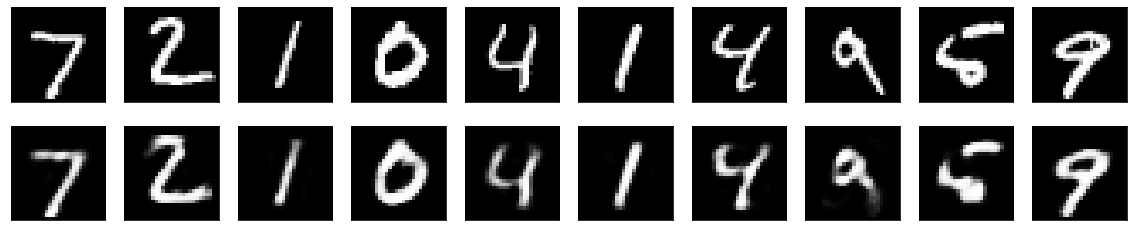

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
